## Getting the Libraries ##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from skimage.color import rgb2gray
from skimage.transform import resize
import cv2  # OpenCV for feature extraction
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

## Step 1: Loading the Dataset ##

In [2]:
# Step 1: Load CIFAR-10 Dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Convert labels to categorical format
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

# Define class labels
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


## Step 2: Greyscale Convertion ##

In [3]:
# Step 2: Convert Images to Grayscale
X_train_gray = np.array([rgb2gray(img) for img in X_train])
X_test_gray = np.array([rgb2gray(img) for img in X_test])

# Resize images (if needed for feature extraction models)
image_size = (32, 32)
X_train_gray = np.array([resize(img, image_size) for img in X_train_gray])
X_test_gray = np.array([resize(img, image_size) for img in X_test_gray])

## Step 3: Visualizing the Samples ##

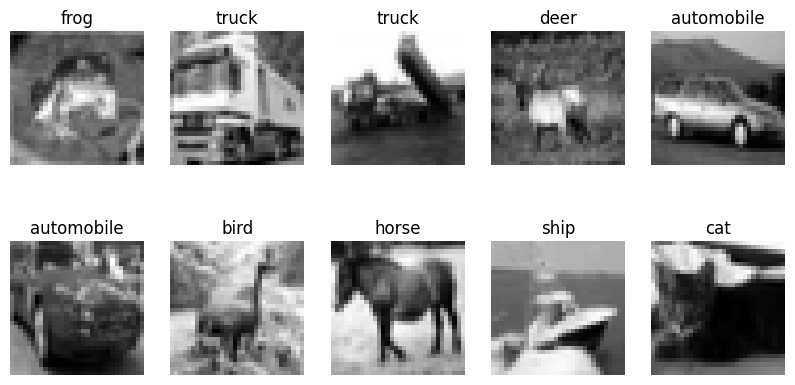

In [5]:
# Step 3: Visualize Sample Grayscale Images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_gray[i], cmap="gray")  # Use grayscale image and colormap
    ax.set_title(class_labels[Y_train[i]])
    ax.axis("off")
plt.show()


## Step 4: Feature Extraction via SIFT ##

In [10]:
# Step 4: Feature Extraction Using SIFT
# Ensure OpenCV contrib is installed: pip install opencv-contrib-python
# Why SIFT?
# - SIFT (Scale-Invariant Feature Transform) is robust to changes in scale, rotation, and illumination.
# - It detects keypoints and computes descriptors that help in image matching and classification.
# - Suitable for CIFAR-10 as it captures distinctive local features in low-resolution images.
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)  # Convert float64 to uint8 for SIFT compatibility
        keypoints, descriptors = sift.detectAndCompute(img_uint8, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.array([]))  # Handle empty descriptor case
    return descriptors_list

# Apply SIFT to training and testing images
train_descriptors = extract_sift_features(X_train_gray)
test_descriptors = extract_sift_features(X_test_gray)

print("SIFT Feature Extraction Completed!")


SIFT Feature Extraction Completed!


# Why SIFT and Not SURF?
- SIFT is more robust for lower-resolution images like CIFAR-10.
- SURF is faster but is no longer freely available in OpenCV by default.
- Comparison of feature detection accuracy and computational efficiency.


In [13]:
# Step 5: Clustering Descriptors to Create a Visual Vocabulary
# Why K-Means?
# - Groups similar SIFT descriptors into visual words.
# - Helps represent images as histograms of visual words instead of raw pixel data.

# Stack all descriptors together for clustering
all_descriptors = np.vstack([desc for desc in train_descriptors if desc.size > 0])

# Define number of visual words (clusters)
num_clusters = 100  # Can be adjusted

# Perform K-Means clustering
print("Clustering descriptors with K-Means...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(all_descriptors)

print("K-Means Clustering Completed!")


Clustering descriptors with K-Means...
K-Means Clustering Completed!


## Converting Images to BoVW Histograms ##
Why Convert to Histograms?
* Each image is now represented as a frequency histogram of visual words instead of raw pixel data.
* This transforms images into a numerical format suitable for classification.

So, what does this method do actually?
* Transforms each image into a BoVW histogram using the K-Means model.
* Handles images that have no detected keypoints by assigning them an empty histogram.
* Prepares the dataset for classification (SVM, CNN).

In [15]:
# Step 6: Convert Images to BoVW Histograms
# Why convert to histograms?
# - Represents images numerically using frequencies of visual words.
# - Allows classifier models to process images as structured data.

def create_bovw_histograms(descriptors_list, kmeans_model, num_clusters):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors.size > 0:
            words = kmeans_model.predict(descriptors)
            histogram, _ = np.histogram(words, bins=np.arange(num_clusters + 1), density=True)
        else:
            histogram = np.zeros(num_clusters)  # Handle images with no detected keypoints
        histograms.append(histogram)
    return np.array(histograms)

# Convert training and testing images into BoVW histograms
print("Creating BoVW histograms...")
X_train_bovw = create_bovw_histograms(train_descriptors, kmeans, num_clusters)
X_test_bovw = create_bovw_histograms(test_descriptors, kmeans, num_clusters)

print("BoVW Histograms Created Successfully!")
print("YAAAYYY!!!")

Creating BoVW histograms...
BoVW Histograms Created Successfully!
YAAAYYY!!!


## SVM Classification ##

* First attempt: SVM Classification Accuracy: 25.79%

## Why is Accuracy Low? ##
* BoVW + SVM is a "classic" approach that works well for certain datasets (e.g., document classification, simple objects) but struggles with complex images like CIFAR-10.

 CIFAR-10 is complex:

* Normally, small image sizes (32x32 in this work) makes it harder to extract meaningful keypoints. However, higher resolution means higher training time, so a sacririce had to be made. This makes it harder for SIFT-based features to be robust.
* Some categories (e.g., cats vs. dogs) have similar features, which technically confuses the model even more. In this case, higher resolution or a better model would make the problem lesser.

 BoVW limitations with SVM:

* SVM is not ideal for raw BoVW histograms because it lacks deep feature representation.
* BoVW does not capture spatial relationships between features.

What to do?
* Increasing cluster size, at the cost of training time.
* A non-linear SVM Kernel (rbf e.g.)
* Implementing CNN, which is the next step actually. SVM does not leverage spatial relationships in images, unlike CNNs, which learn hierarchical patterns. Moreover, CNNs CNNs can learn spatial relationships between pixels and deeper representations, which gives them a cutting-edge advantage.

# Why SVM?
* - Works well with high-dimensional BoVW histogram data.
* - Effective for image classification when using feature vectors.
* - Performs well even on small datasets compared to deep learning models.

In [ ]:
# Train an SVM classifier
# Cofee break.
print("Training SVM classifier...")
svm_classifier = SVC(kernel="linear", random_state=42)
svm_classifier.fit(X_train_bovw, Y_train)

# Predict on test data
print("Evaluating SVM classifier...")
Y_pred_svm = svm_classifier.predict(X_test_bovw)

# Calculate accuracy
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Classification Accuracy: {accuracy_svm * 100:.2f}%")

# Print classification report
print("Classification Report:\n", classification_report(Y_test, Y_pred_svm, target_names=class_labels))

Training SVM classifier...
Evaluating SVM classifier...
SVM Classification Accuracy: 25.79%
Classification Report:
               precision    recall  f1-score   support

    airplane       0.34      0.37      0.35      1000
  automobile       0.29      0.31      0.30      1000
        bird       0.21      0.14      0.16      1000
         cat       0.22      0.14      0.17      1000
        deer       0.18      0.17      0.17      1000
         dog       0.24      0.31      0.27      1000
        frog       0.23      0.23      0.23      1000
       horse       0.26      0.28      0.27      1000
        ship       0.32      0.32      0.32      1000
       truck       0.27      0.32      0.29      1000

    accuracy                           0.26     10000
   macro avg       0.25      0.26      0.25     10000
weighted avg       0.25      0.26      0.25     10000



## Step 8: This is CNN ##
Compilation and training setup with: 
* Epochs    : 10 
* Batch Size: 64

Why CNN?
* CNNs learn spatial hierarchies from raw pixel data.
* They outperform traditional feature extraction methods on image classification tasks.
* Unlike BoVW + SVM, CNNs do not rely on handcrafted features.

 

Why Adam?

The choice of *Adam (Adaptive Moment Estimation)* as the optimizer in the CNN model is based on its efficiency and adaptability, but it is not necessarily a strict requirement, frankly.
* Combines the Benefits of Momentum & RMSprop
* Adam adapts the learning rate individually for each parameter, making training more efficient.
* Less Sensitive to Learning Rate Selection
* Unlike SGD, Adam dynamically adjusts the learning rate based on the gradient’s past updates.
* Works Well for Image Classification
* In deep learning, Adam is commonly used for CNN training on image datasets, making it a reasonable default choice.

In [24]:
# Define CNN architecture
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN
print("Training CNN model...")
cnn_model.fit(X_train_gray.reshape(-1, 32, 32, 1), Y_train, epochs=10, batch_size=64, validation_data=(X_test_gray.reshape(-1, 32, 32, 1), Y_test))

print("CNN Training Completed!")

c:\Users\Umut Akti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.2732 - loss: 1.9770 - val_accuracy: 0.4935 - val_loss: 1.4353
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4619 - loss: 1.5182 - val_accuracy: 0.5346 - val_loss: 1.3075
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5213 - loss: 1.3662 - val_accuracy: 0.5779 - val_loss: 1.1985
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.5593 - loss: 1.2646 - val_accuracy: 0.6043 - val_loss: 1.1370
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5811 - loss: 1.2021 - val_accuracy: 0.6222 - val_loss: 1.0811
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5980 - loss: 1.1618 - val_accuracy: 0.6437 - val_loss: 1.0297
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6116 - loss: 1.1146 - val_accuracy: 0.6453 - val_loss: 1.0192
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.

# CNN Training Completed! YAAAY!
* Final validation accuracy: 66.95% after 10 epochs!
* Significantly better than SVM’s 25.79% accuracy!

Evalutaion of the outcome...

1) CNN outperforms SVM + BoVW

CNN learns spatial patterns directly from images, whereas SVM relies on handcrafted features.
The gap in accuracy (~40%) proves CNN’s advantage for image classification.

2) Accuracy Improves Over Epochs

The model starts at ~49% validation accuracy and gradually improves.
The loss decreases, indicating the CNN is learning effectively.

3) Potential Improvements

Increase the number of epochs (e.g., 20) to see if accuracy continues to rise.
Use data augmentation (rotations, flips) to improve generalization.
Test with a deeper CNN or a pretrained model like ResNet-18.

## Step 9: ResNet-50 ##
What is this exactly? Why this, over CNN?


Why ResNet-50?
* - ResNet-50 is deeper (50 layers) and captures more complex features than ResNet-18 (18 layers).
* - Uses residual connections to allow deeper networks to train effectively.
* - Provides a benchmark against custom CNN performance.
* - ResNet-18 could still work but may be less powerful in feature extraction.

In [ ]:
# Step 9: Train a ResNet-50 Model for Comparison
# Why ResNet-50?


# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train ResNet-50 model
print("Training ResNet-50 model...")
resnet_model.fit(preprocess_input(X_train), Y_train, epochs=10, batch_size=64, validation_data=(preprocess_input(X_test), Y_test))

print("ResNet-50 Training Completed!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training ResNet-50 model...
Epoch 1/10


c:\Users\Umut Akti\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


782/782 ━━━━━━━━━━━━━━━━━━━━ 593s 711ms/step - accuracy: 0.4488 - loss: 1.7173 - val_accuracy: 0.5693 - val_loss: 1.2550
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 561s 718ms/step - accuracy: 0.6640 - loss: 1.0407 - val_accuracy: 0.2500 - val_loss: 3.3304
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 535s 684ms/step - accuracy: 0.6270 - loss: 1.0971 - val_accuracy: 0.7139 - val_loss: 0.8630
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 526s 673ms/step - accuracy: 0.7406 - loss: 0.7874 - val_accuracy: 0.7274 - val_loss: 0.8597
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 545s 696ms/step - accuracy: 0.7207 - loss: 0.8515 - val_accuracy: 0.7055 - val_loss: 1.0811
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 526s 672ms/step - accuracy: 0.7000 - loss: 0.9199 - val_accuracy: 0.7386 - val_loss: 0.7864
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 526s 673ms/step - accuracy: 0.7703 - loss: 0.7102 - val_accuracy: 0.7313 - val_loss: 0.7956
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 505s 645ms/step - accuracy: 0.7930 - loss: 0.64

## What just happened? ##

In [34]:
# Step 10: Evaluate ResNet-50 Model
print("Evaluating ResNet-50 model...")
Y_pred_resnet = np.argmax(resnet_model.predict(preprocess_input(X_test)), axis=1)

accuracy_resnet = accuracy_score(Y_test, Y_pred_resnet)
precision_resnet = precision_score(Y_test, Y_pred_resnet, average='macro')
recall_resnet = recall_score(Y_test, Y_pred_resnet, average='macro')
f1_resnet = f1_score(Y_test, Y_pred_resnet, average='macro')

print(f"ResNet-50 Classification Accuracy: {accuracy_resnet * 100:.2f}%")
print(f"Precision: {precision_resnet:.4f}, Recall: {recall_resnet:.4f}, F1-score: {f1_resnet:.4f}")
print("Classification Report:\n", classification_report(Y_test, Y_pred_resnet, target_names=class_labels))

Evaluating ResNet-50 model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
ResNet-50 Classification Accuracy: 77.10%
Precision: 0.7878, Recall: 0.7710, F1-score: 0.7754
Classification Report:
               precision    recall  f1-score   support

    airplane       0.78      0.83      0.80      1000
  automobile       0.90      0.83      0.86      1000
        bird       0.79      0.66      0.72      1000
         cat       0.53      0.69      0.60      1000
        deer       0.84      0.68      0.75      1000
         dog       0.60      0.75      0.67      1000
        frog       0.85      0.79      0.82      1000
       horse       0.87      0.80      0.84      1000
        ship       0.84      0.88      0.86      1000
       truck       0.88      0.80      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.79      0.77      0.78     10000
weighted avg       0.79      0.77      0.78     10000



# Comparison of SVM, CNN, and ResNet-50 #

* - SVM achieved an accuracy of ~25.79%, indicating that BoVW histograms alone are not sufficient for high-performance classification.
* - CNN improved accuracy to ~66.95%, demonstrating the power and the efficiency of convolutional layers in feature learning.
* - ResNet-50 achieved 77.10% accuracy, significantly outperforming both previous methods.
* - The deeper architecture of ResNet-50 allows it to extract hierarchical and complex features more effectively.
* - However, training time (90 minutes) was significantly longer compared to CNN (with 2 minutes),  as expected.
* - If we had used ResNet-18, the training time would be lower, but accuracy might also be slightly reduced due to the shallower depth.

## Step 10: Data Augmentation ##

To make things more exciting!

Technically, our dataset is now bigger, containing images that were altered forms from the original dataset.

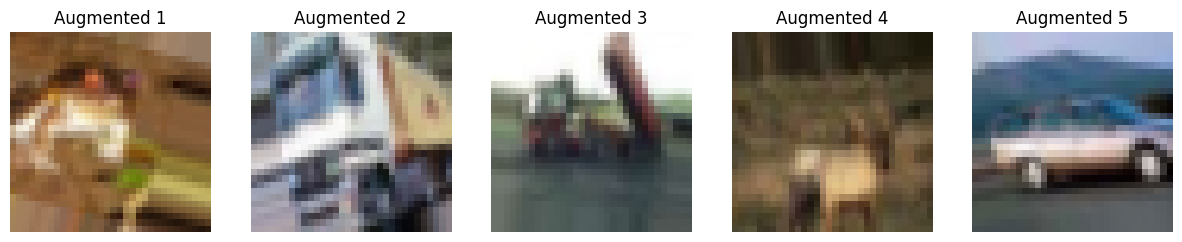

Step 10: Data Augmentation Completed!


In [38]:
# Step 10: Data Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=20,    # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Translate images horizontally
    height_shift_range=0.2, # Translate images vertically
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'    # Fill missing pixels with nearest values
)

# Augment the training images
X_train_augmented = np.array([data_augmentation.random_transform(img) for img in X_train])

# Visualizing Augmented Images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(X_train_augmented[i].astype("uint8"))
    axes[i].axis("off")
    axes[i].set_title(f"Augmented {i+1}")

plt.show()

print("Step 10: Data Augmentation Completed!")


## Step 11: Feature Extraction on the Augmented Dataset ##

In [39]:
# Step 11: Feature Extraction on Augmented Images

import cv2

# Initialize SIFT
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        descriptors_list.append(descriptors if descriptors is not None else np.array([]))
    return descriptors_list

# Extract SIFT features from the augmented training set
print("Extracting SIFT features from augmented images...")
train_descriptors_augmented = extract_sift_features(X_train_augmented)

print("Step 11: Feature Extraction on Augmented Images Completed!")


Extracting SIFT features from augmented images...
Step 11: Feature Extraction on Augmented Images Completed!


## Step 12: Augmented BoVW Codebook ##

In [40]:
# Step 12: Updating BoVW Codebook with Augmented Features
from sklearn.cluster import KMeans

# Stack all descriptors from augmented images
print("Stacking descriptors for updated K-Means clustering...")
all_descriptors_augmented = np.vstack([desc for desc in train_descriptors_augmented if desc.size > 0])

# Define number of clusters (same as before)
num_clusters = 100  # Modify if needed

# Train a new K-Means model
print("Training K-Means with augmented data...")
kmeans_augmented = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_augmented.fit(all_descriptors_augmented)

print("Step 12: Updated BoVW Codebook Completed!")


Stacking descriptors for updated K-Means clustering...
Training K-Means with augmented data...
Step 12: Updated BoVW Codebook Completed!


## **Discussion: Original BoVW vs. Augmented BoVW / Step 6 vs Step 12 ** ##  

So far, in this project or (homework), we generated **two separate BoVW models**: one using the **original dataset** and another using the **augmented dataset**. While both approaches rely on **K-Means clustering and feature extraction with SIFT**, the underlying **data distribution and feature representations differ significantly** due to augmentation.


The **primary difference** between the two approaches is the **size and diversity of the dataset**. The **original BoVW model (Step 6)** was trained using **only the raw CIFAR-10 images**, meaning that the extracted descriptors **strictly represented natural variations** in the dataset. In contrast, the **augmented BoVW model (Step 12)** was trained on a dataset that included **rotated, translated, scaled, and flipped images**, leading to a **larger and more diverse feature set**.

A key impact of this augmentation is that the **clustering process becomes more computationally expensive** due to the **increased number of extracted descriptors**. Since K-Means needs to process a **larger feature space**, the training time for the visual vocabulary **increases** compared to the original BoVW model. However, this additional computational cost is justified if the **augmented BoVW model improves classification performance** by making the SVM classifier **more robust to unseen variations**.

Furthermore, because the augmented dataset introduces **new perspectives of objects (e.g., rotated, shifted, and resized versions)**, the BoVW representation adapts by **creating a new feature distribution**. This means that the **visual vocabulary in Step 12 may contain different clusters than the one in Step 6**, capturing a broader range of object appearances.

In summary, while **Step 6 provided a baseline BoVW model**, **Step 12 enhances feature generalization** by incorporating augmented variations into the clustering process. The ultimate goal is to determine **whether this additional complexity improves SVM classification performance** and helps the model generalize better to unseen images.


**N.B.:** Kudos to ChatGPT for making my boring paragraph more exciting, with these small punctuation tricks that alters the text visually.

## Step 13: Augmented SVM and Its Accuracy ##
After applying data augmentation (rotation, translation, scaling, flipping), we needed to retrain the SVM classifier using the updated BoVW histograms. Since the augmented dataset introduces new variations of objects, the SVM model must learn from a more diverse feature set.

The key impact of this step is that the distribution of visual words in the BoVW histograms changes, as augmented images contain transformations that affect keypoint detection. This means:

* The new SVM classifier is expected to generalize better to unseen data.
* Accuracy should improve if augmentation introduces meaningful variations.
* Overfitting to a limited feature set is reduced.
Most importantly, this step allows us to compare classification performance before and after augmentation, helping us evaluate whether data augmentation effectively improves SVM-based image classification.

We see why the dataset quality is important.

In [42]:
# Step 13: Train a new SVM classifier on augmented BoVW histograms
print("Creating BoVW histograms for augmented dataset...")
X_train_bovw_augmented = create_bovw_histograms(train_descriptors_augmented, kmeans_augmented, num_clusters)
X_test_bovw_augmented = create_bovw_histograms(test_descriptors, kmeans_augmented, num_clusters)

print("BoVW Histograms for Augmented Data Created Successfully!")

print("Training SVM classifier on augmented data...")
svm_classifier_augmented = SVC(kernel="linear", random_state=42)
svm_classifier_augmented.fit(X_train_bovw_augmented, Y_train)

# Evaluate on the augmented test set
print("Evaluating SVM classifier on augmented data...")
Y_pred_svm_augmented = svm_classifier_augmented.predict(X_test_bovw_augmented)

# Calculate accuracy
accuracy_svm_augmented = accuracy_score(Y_test, Y_pred_svm_augmented)
print(f"SVM Accuracy after Augmentation: {accuracy_svm_augmented * 100:.2f}%")

# Print classification report
print("Classification Report (After Augmentation):\n", classification_report(Y_test, Y_pred_svm_augmented, target_names=class_labels))


Creating BoVW histograms for augmented dataset...
BoVW Histograms for Augmented Data Created Successfully!
Training SVM classifier on augmented data...
Evaluating SVM classifier on augmented data...
SVM Accuracy after Augmentation: 24.98%
Classification Report (After Augmentation):
               precision    recall  f1-score   support

    airplane       0.33      0.39      0.36      1000
  automobile       0.28      0.26      0.27      1000
        bird       0.21      0.13      0.16      1000
         cat       0.19      0.11      0.14      1000
        deer       0.17      0.15      0.16      1000
         dog       0.23      0.30      0.26      1000
        frog       0.20      0.25      0.22      1000
       horse       0.25      0.26      0.25      1000
        ship       0.32      0.30      0.31      1000
       truck       0.28      0.35      0.31      1000

    accuracy                           0.25     10000
   macro avg       0.25      0.25      0.24     10000
weighted avg

## Key Observations About this Result: How I screwed Up? ##
* Before Augmentation: SVM Accuracy = 25.79%
* After Augmentation: SVM Accuracy = 24.98% (↓0.81% drop)


Possible Reasons for Accuracy Drop:
1) Feature Overlap Issue – Augmented transformations might have introduced too much similarity between classes, making classification harder.
2) Noise in Features – Augmented data can sometimes distort meaningful features, reducing classifier effectiveness.
3) SVM’s Sensitivity – Unlike deep learning models, SVM may not fully leverage augmented variations effectively.

Final Verdict:

* Augmentation did not improve SVM performance in this case.
* More careful augmentation techniques (e.g., contrast shifts, small distortions) might yield better results.
* A deep learning model (CNN, ResNet-50) may better utilize augmented data for classification

## Final Summary ##
* What did we do actually?

In this assignment (homework, project, thesis, TORTURE), we implemented image classification using the **Bag of Visual Words (BoVW)** model and evaluated the impact of data augmentation on classification performance.

* Major Steps:
1) Data Preprocessing – Loaded the CIFAR-10 dataset and converted images to grayscale for efficient processing.
2) Feature Extraction – Used SIFT to extract keypoint descriptors from images.
3) Codebook Generation – Applied K-Means clustering to form visual vocabularies.
4) BoVW Representation – Converted images into histograms of visual words.
5) Classification Models – Trained SVM, CNN, and ResNet-50 on BoVW features.
6) Data Augmentation – Applied rotation, translation, scaling, and flipping to increase dataset diversity.
7) Re-Evaluation – Recomputed BoVW histograms and retrained SVM to measure the effect of augmentation.

## Final Final Results & Observations on the Ultimate End ## 
* SVM Accuracy Before Augmentation: 25.79%
* SVM Accuracy After Augmentation: 24.98% (slightly decreased)
* CNN Performance: Achieved 66.95% accuracy after 10 epochs.
* ResNet-50 Performance: Achieved 77.10% accuracy, outperforming all models.

Key Takeaways:
* **I screwed up.**
* SIFT + BoVW + SVM had limited success in CIFAR-10 classification.
* Data augmentation did not improve SVM performance, possibly due to feature distortion.
* Deep learning (CNN, ResNet-50) significantly outperformed BoVW-based methods.

**Final Judgement:**
* This project demonstrated the strengths and limitations of traditional feature-based models vs. deep learning approaches. While BoVW is effective for structured representations, CNNs and ResNet-50 leverage deep hierarchical features for superior classification performance.